# Overview

In this notebook a simple sequential linear model will be buitl using pytorch neural network module. The model and input data will be pushed to a CUDA device for quick calculation. 

## Import Libraries

In [248]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn #neural network
import torchvision as tv
import torchvision.transforms as TF
import torch.optim as optim # optimizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Set Cuda Device and Import Data

In [605]:
# set test device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [558]:
index_df = pd.read_csv("../../data/image_index.csv", index_col=0)
index_df.head()

,img,data_set,condition
0,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
1,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
2,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
3,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
4,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0


In [562]:
index_df.head()

,img,data_set,condition,negative,positive
0,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0,1,0
1,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0,1,0
2,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0,1,0
3,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0,1,0
4,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0,1,0


## Make Train Test Split

In [705]:
test_df = index_df[index_df.data_set==0]
train_df = index_df[index_df.data_set==1]

In [706]:
train_data = train_df[["img","condition"]].sample(30, random_state = 42)

In [708]:
y_true = torch.tensor(train_data["condition"].values).float()

In [709]:
img_paths = train_data.img.values

In [710]:
y_true.shape

torch.Size([30])

## Preprocess Data for Modeling

In [676]:
## update this to sequential?
def preprocess_image_flat(path_list, img_h=120, img_w=120):
    outlist = []
    for path in path_list:
        resizer = TF.Resize((img_h, img_w)) #define resizer per new_h and new_w
        im = tv.io.read_image(path).type(torch.float) #read image as pytorch float tensor
        im = resizer(im) #resize image
        normalizer = TF.Normalize(im.mean(), im.std()) #initialize normalizer
        im = normalizer(im) # return normalized pytorch float tensor
        im = torch.flatten(im)
        outlist.append(im)
    return torch.stack(outlist)

In [677]:
input_data = preprocess_image_flat(img_paths)

In [678]:
input_data = input_data.to(device)

In [679]:
input_data

tensor([[-1.4325, -1.4333, -1.4134,  ..., -1.4453, -1.4453, -1.4453],
        [-1.9128, -1.8097, -1.6496,  ..., -2.0894, -2.0894, -2.0894],
        [-1.3663, -1.2909, -1.2273,  ..., -1.4563,  0.6902,  0.7155],
        ...,
        [-0.3183, -0.2032, -1.0656,  ..., -1.6457, -1.6457, -1.6457],
        [-0.8491, -0.8987, -1.0497,  ..., -1.5477, -1.2935, -0.6150],
        [-1.7011, -1.3153, -1.1172,  ..., -2.0501, -2.0501, -2.0501]],
       device='cuda:0')

In [724]:
class linear_prototype3(nn.Module):
    def __init__(self, img_h, img_w):
        super().__init__()
        #define sizes here
        self.h = img_h
        self.w = img_w
        self.longshape = img_h*img_w
        self.linear1 = nn.Linear(self.longshape, 320)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(320, 1)
        self.softmax = nn.Softmax(dim=1)
        self.termn_act = nn.Sigmoid()
    
    def forward(self, x):
        # preprocess the input image
        #============ Layer1==============#
        x = self.linear1(x)
        x = self.relu1(x)
        #============Layer2==============#
        x = self.linear2(x)
        #x = self.softmax(x)
        x = self.termn_act(x)
        return x

## Optimizer

In [734]:
model = linear_prototype3(120, 120)

In [735]:
model.to(device)

linear_prototype3(
  (linear1): Linear(in_features=14400, out_features=320, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=320, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
  (termn_act): Sigmoid()
)

In [736]:
next(model.parameters()).is_cuda

True

In [737]:
y = model(input_data)

In [738]:
y.shape

torch.Size([30, 1])

In [739]:
y.flatten().shape

torch.Size([30])

In [740]:
criterion = torch.nn.BCELoss()

In [742]:
def run_optim(n_seq, learning_rate, img_paths, y_true):
    y_true = y_true.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for t in range(n_seq):

        y_pred = model(img_paths).flatten()
        loss = criterion(y_pred, y_true) #calculate loss
        if t%100 == 0:
            print("training epoch", t)
            loss_copy = loss.detach().cpu()
        plt.scatter(t, loss_copy)
        optimizer.zero_grad() #reset gradient)
        
        # gradient back step
        loss.backward()
    
        optimizer.step()
        
        # update parameters per learning rate (go down the gradient)
        with torch.no_grad(): #sequential
            for param in model.parameters():
                param += learning_rate * param.grad

training epoch 0
training epoch 100
training epoch 200
training epoch 300
training epoch 400
training epoch 500
training epoch 600
training epoch 700
training epoch 800
training epoch 900


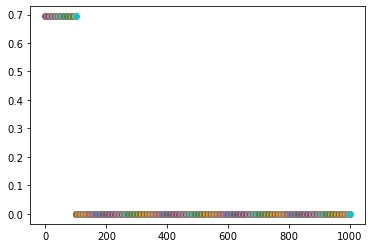

In [743]:
run_optim(1000, 0.001, input_data, y_true)

this model reduces loss to 0 in about ~100 iterations

In [744]:
save_path = "../../models/pneumonia_simple_01.pt"
torch.save(model.state_dict(), save_path)

***
## Old Model Iteration

These are saved for future reference and/or troubleshooting

***


## First Linear Prototype

The issue with this model is that the output is `[1, 640, 2]` when the output should be a shape of `[2,]`. 

A flattening maybe required

In [108]:
class linear_prototype(nn.Module):
    def __init__(self, img_h, img_w):
        super().__init__()
        #define sizes here
        self.h = img_h
        self.w = img_w
        self.linear1 = nn.Linear(img_w, 320)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(320, 2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # preprocess the input image
        x = self.preprocess_image(x)
        #============ Layer1==============#
        x = self.linear1(x)
        x = self.relu1(x)
        #============Layer2==============#
        x = self.linear2(x)
        
        return self.softmax(x)
    
    ## update this to sequential?
    def preprocess_image(self, path):
        resizer = TF.Resize((self.h, self.w)) #define resizer per new_h and new_w
        im = tv.io.read_image(path).type(torch.float) #read image as pytorch float tensor
        im = resizer(im) #resize image
        normalizer = TF.Normalize(im.mean(), im.std()) #initialize normalizer
        return normalizer(im) # return normalized pytorch float tensor

In [109]:
proto_model = linear_prototype(640, 640)

In [110]:
proto_model

linear_prototype(
  (linear1): Linear(in_features=640, out_features=320, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=320, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [112]:
y_pred = proto_model(test_image_path)

In [113]:
y_pred.shape

torch.Size([1, 640, 2])

### First Model Optimizer

Runs into tensor placement errors

In [472]:
def run_optim2(n_seq, learning_rate, img_path_list):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for t in range(n_seq):
        y_pred = [model(path) for path in img_path_list]
        y_pred = torch.tensor([1 if pred[0] > pred[1] else 0 for pred in y_pred]).float()
        y_pred = y_pred.clone().detach().requires_grad_(True)
        
        loss = criterion(y_pred, y_true) #calculate loss

        plt.scatter(t, loss.detach())
        optimizer.zero_grad() #reset gradient)
        
        # gradient back step
        loss.backward()
    
        optimizer.step()
        
        # update parameters per learning rate (go down the gradient)
        with torch.no_grad(): #sequential
            for param in model.parameters():
                if param.grad is not None:
                    param += learning_rate * param.grad

# Second Linear Prototype with Flattened Tensor

In [712]:
class linear_prototype2(nn.Module):
    def __init__(self, img_h, img_w):
        super().__init__()
        #define sizes here
        self.h = img_h
        self.w = img_w
        self.longshape = img_h*img_w
        self.linear1 = nn.Linear(self.longshape, 320)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(320, 2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # preprocess the input image
        x = self.preprocess_image_flat(x)
        #============ Layer1==============#
        x = self.linear1(x)
        x = self.relu1(x)
        #============Layer2==============#
        x = self.linear2(x)
        return x
    
    ## update this to sequential?
    def preprocess_image_flat(self, path):
        resizer = TF.Resize((self.h, self.w)) #define resizer per new_h and new_w
        im = tv.io.read_image(path).type(torch.float) #read image as pytorch float tensor
        im = resizer(im) #resize image
        normalizer = TF.Normalize(im.mean(), im.std()) #initialize normalizer
        im = normalizer(im) # return normalized pytorch float tensor
        im = torch.flatten(im)
        return im.clone().detach().requires_grad_(True)